In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import pickle as pkl

from IPython.display import HTML
matplotlib.rcParams.update({'font.size': 14})

In [79]:
# Load PINN outputs
with open('total_loss.pkl', 'rb') as file:
    total_loss = pkl.load(file)

with open('pinn_loss.pkl', 'rb') as file:
    pinn_loss = pkl.load(file)
    
with open('boundary_loss.pkl', 'rb') as file:
    boundary_loss = pkl.load(file)
    
with open('predictions.pkl', 'rb') as file:
    predictions = pkl.load(file)
    
with open('f_boundary.pkl', 'rb') as file:
    f_boundary = pkl.load(file)
    
with open('p.pkl', 'rb') as file:
    p = pkl.load(file)

In [80]:
# Get size and check inputs
size = int(np.sqrt(f_predict.shape[0]))

print(f'F_boundary shape: {f_boundary.shape}, max: {np.max(f_boundary)}')
print(f'Predictions shape: {predictions.shape}, max: {np.max(predictions[:, :, -1].reshape((size, size)).T[:-1, -1])}')

F_boundary shape: (256, 1), max: 6.435430020812451
Predictions shape: (65536, 1, 1), max: -2.5177435874938965


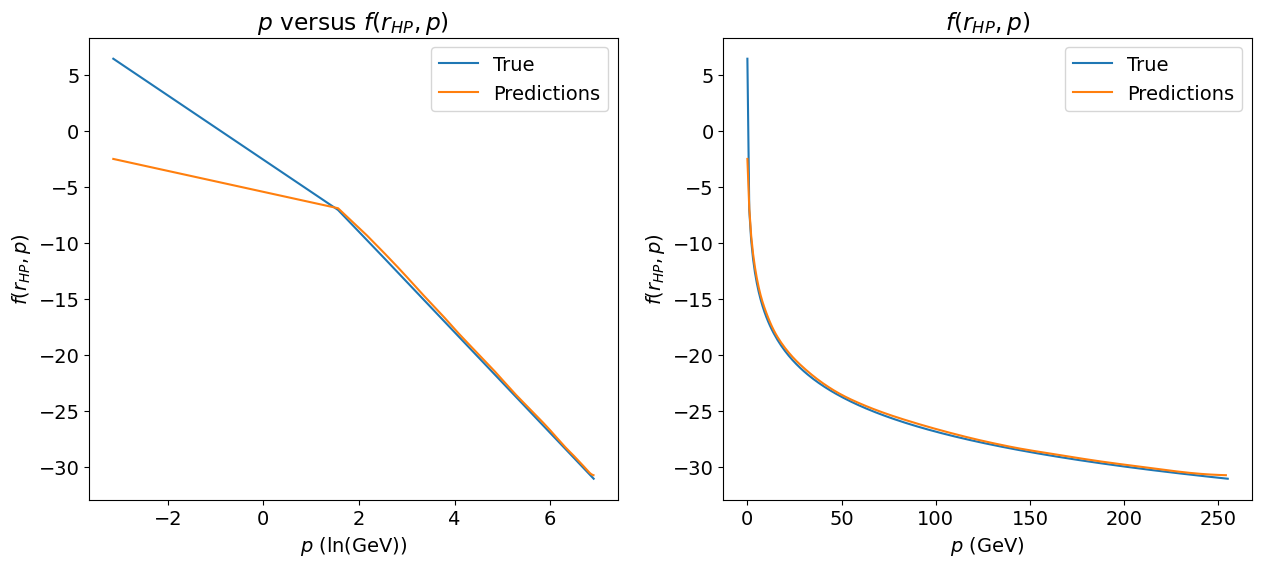

In [81]:
# Plot prediction and boundary data at r_HP = 120 AU
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(p, f_boundary, label='True')
ax[0].plot(p[:-1], predictions[:, :, -1].reshape((size, size)).T[:-1, -1], label='Predictions') # Has added [0.] element from preds bug. Ignore final indice
ax[0].set_title("$p$ versus $f(r_{HP}, p)$")
ax[0].set_xlabel("$p$ (ln(GeV))")
ax[0].set_ylabel("$f(r_{HP}, p)$")
ax[0].legend()

ax[1].plot(f_boundary, label='True')
ax[1].plot(predictions[:, :, -1].reshape((size, size)).T[:-1, -1], label='Predictions') # Has added [0.] element from preds bug. Ignore final indice
ax[1].set_title("$f(r_{HP}, p)$")
ax[1].set_xlabel("$p$ (GeV)")
ax[1].set_ylabel("$f(r_{HP}, p)$")
ax[1].legend()

plt.savefig("boundary.png")

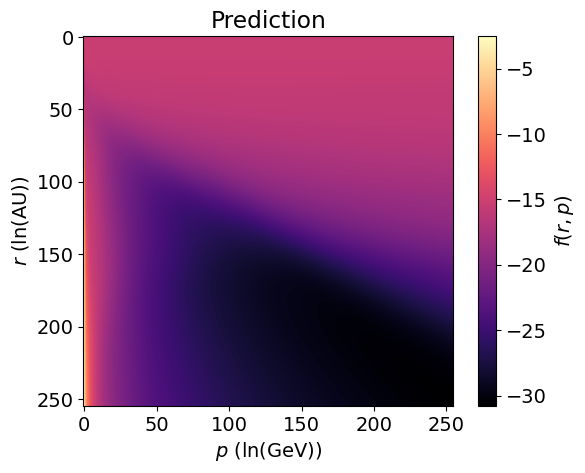

In [82]:
# Plot prediction at the final epoch
plt.imshow(predictions[:, :, -1].reshape((size, size))[:-1, :-1], cmap='magma')
plt.colorbar(label='$f(r, p)$')

plt.title('Prediction')
plt.xlabel('$p$ (ln(GeV))')
plt.ylabel('$r$ (ln(AU))')
plt.savefig("prediction.png")

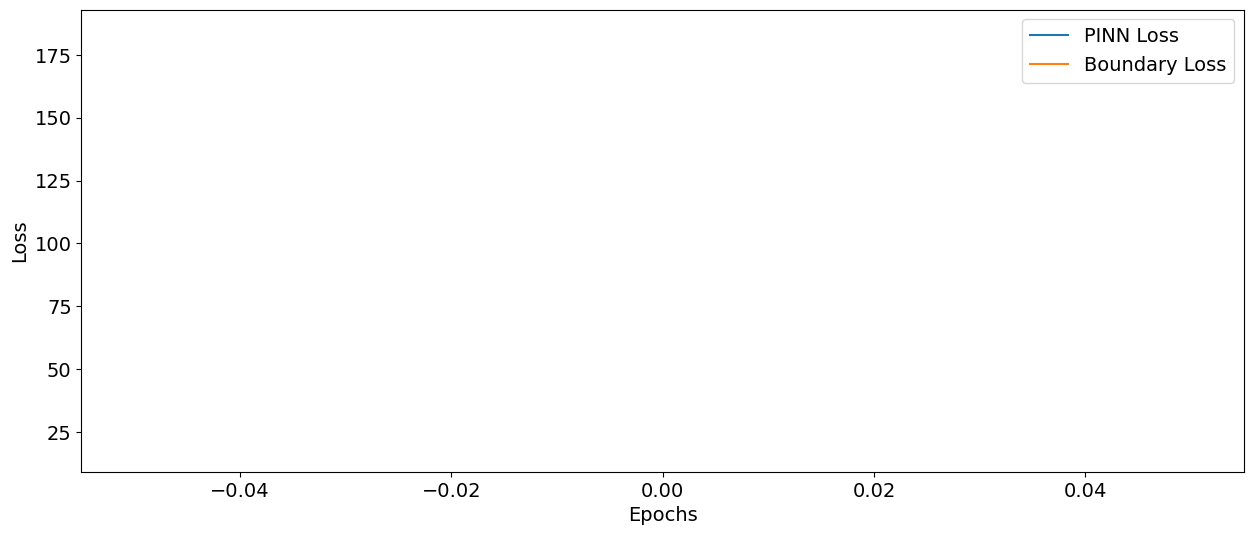

In [25]:
# Plot loss 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax.plot(pinn_loss, label='PINN Loss')
ax.plot(boundary_loss, label='Boundary Loss')
# ax.plot(total_loss, label='Total Loss')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.savefig("loss.png")

In [ ]:
# Create gif of prediction throughout the epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ims = []
for i in range(predictions.shape[2]):
    if i == 0:
        ax.set_xlabel('$p$ (ln(GeV))')
        ax.set_ylabel('$r$ (ln(AU))')
    
    txt = plt.text(0.5, 0.95, f"Epoch: {i}", transform=ax.transAxes, ha="center", color='w')
    im = ax.imshow(predictions[:, :, i].reshape((size, size))[:-1, :-1], animated=True, cmap='magma')
    ims.append([im, txt])
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())

In [ ]:
# Save gif
writergif = animation.PillowWriter(fps=30)
ani.save('predict.gif', writer=writergif)